# Multi-objective Robust Optimization (MORO) for the intertemporal lake_problem

Follow the guidelines for the DPS_MORO assignment, but use the intertemporal version of the lake problem as used in previous weeks. 

Again, this is very time consuming. You will need at least 100.000 function evaluations to get decent results. 

Visualize the performance of the solutions using parallel coordinate plots. What do you observe?

In [2]:
from intertemporal import cython_lake_model as lake_problem


# or 
# from lakemodel_function import lake_problem
# NOTE:: you need to change the levers as well, below

from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter('l{}'.format(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

# or
# lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
#                      range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [3]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)


In [4]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 50
scenarios = sample_uncertainties(lake_model, n_scenarios)
nfe = int(1e4)

In [5]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustnes_functions = [ScalarOutcome('fraction max_p', kind=MAXIMIZE, 
                             variable_name='max_P', function=maxp),
                       ScalarOutcome('fraction reliability', kind=MAXIMIZE, 
                             variable_name='reliability', function=reliability),
                       ScalarOutcome('fraction inertia', kind=MAXIMIZE, 
                             variable_name='inertia', function=inertia),
                       ScalarOutcome('fraction utility', kind=MAXIMIZE, 
                             variable_name='utility', function=utility)]

In [21]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

# requires master branch of workbench
# enables us to avoid logging to many intermediate results
# can be ignored without invalidating results
BaseEvaluator.reporting_frequency = 0.1

ema_logging.log_to_stderr(ema_logging.INFO)

convergence = [HyperVolume(minimum=[0,0,0,0], maximum=[1, 1, 1, 1]),
               EpsilonProgress()]

with MultiprocessingEvaluator(lake_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, 
                                               nfe=10000, convergence=convergence,
                                               epsilons=[0.05,]*len(robustnes_functions))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 400/10000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] performing 50 scena

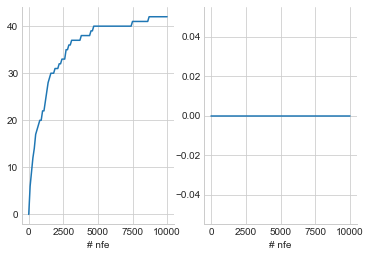

In [22]:
fig, axes = plt.subplots(ncols=2, sharex=True)
axes[0].plot(convergence.nfe, convergence.epsilon_progress)
axes[1].plot(convergence.nfe, convergence.hypervolume)

axes[0].set_xlabel('# nfe')
axes[1].set_xlabel('# nfe')

sns.despine()

plt.show()

/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


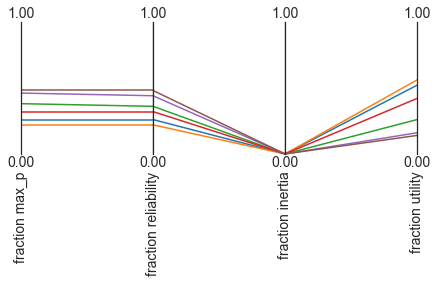

In [23]:
from ema_workbench.analysis import parcoords

output = archive.iloc[:, 100::]
limits = parcoords.get_limits(output)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

axes = parcoords.ParallelAxes(limits)
axes.plot(output)
plt.show()